In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import poissonImg

%matplotlib inline
%load_ext autoreload
%autoreload 2

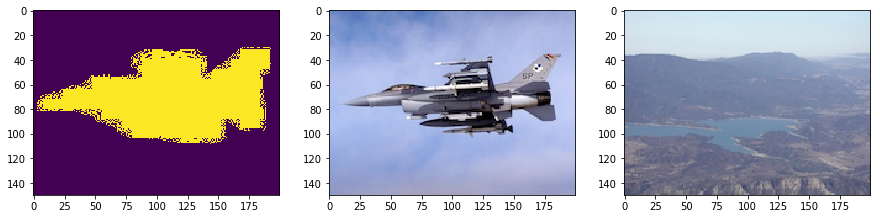

In [3]:
# read images
img_mask = cv2.imread('mask.jpg', cv2.IMREAD_GRAYSCALE)
img_src = cv2.imread('source.jpg', cv2.IMREAD_COLOR)
img_dst = cv2.imread('target.jpg', cv2.IMREAD_COLOR)

# normalize mask
img_mask = img_mask/255
img_mask[img_mask < 1] = 0

# bgr to rgb, float [0,1]
img_src = img_src[:,:,::-1].astype(np.float)/255
img_dst = img_dst[:,:,::-1].astype(np.float)/255

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img_mask)
plt.subplot(1,3,2)
plt.imshow(img_src)
plt.subplot(1,3,3)
plt.imshow(img_dst)

In [4]:
# seamless cloning
channels = img_src.shape[-1]
# Call the poisson method on each individual channel
img_clone = [poissonImg.poisson_clone(img_src[:,:,i],img_dst[:,:,i],img_mask) for i in range(channels)]
# Merge the channels back into one image
img_clone = cv2.merge(img_clone)
#cv2.imwrite('./result.jpg',img_clone)

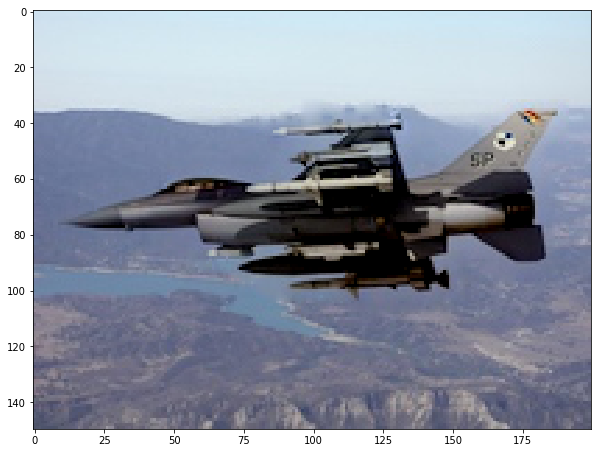

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(img_clone)

Text(0.5,1,'(768, 1024, 3)')

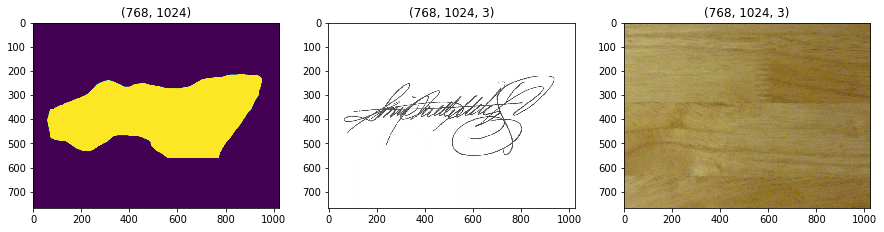

In [65]:
# mixed gradient
# data from http://cs.brown.edu/courses/cs129/results/proj2/damoreno/
im_mask = cv2.imread('mask_10.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float)
im_src = cv2.imread('source_10.jpg', cv2.IMREAD_COLOR).astype(np.float)
im_dst = cv2.imread('target_10.jpg', cv2.IMREAD_COLOR).astype(np.float)

# resize and pad
im_mask = cv2.resize(im_mask, (0,0), fx=768./827., fy=768./827.)
im_src = np.dstack([cv2.resize(im_src[:,:,k], (0,0), fx=768./827., fy=768./827.) for k in range(3)])

pads = []
for k in range(2):
    pad = im_dst.shape[k]-im_mask.shape[k]
    pads.append( (pad//2,pad-pad//2) )
im_mask = np.pad(im_mask,(pads[0],pads[1]),'constant')
im_src = np.pad(im_src,(pads[0],pads[1],(0,0)),'edge')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(im_mask)
plt.title(im_mask.shape)
plt.subplot(1,3,2)
plt.imshow(im_src[:,:,::-1]/255)
plt.title(im_src.shape)
plt.subplot(1,3,3)
plt.imshow(im_dst[:,:,::-1]/255)
plt.title(im_dst.shape)

In [66]:
im_dst = np.pad(im_dst,((1,1),(1,1),(0,0)),'constant')
im_src = np.pad(im_src,((1,1),(1,1),(0,0)),'constant')
im_mask = np.pad(im_mask,((1,1),(1,1)),'edge')

H,W,C = im_dst.shape
im_bin = np.zeros((H,W,C))
im_mix = np.zeros((H,W,C))
for k in range(C):
    # compute gradient
    gx_dst,gy_dst = poissonImg.imgradient(im_dst[:,:,k])
    gx_src,gy_src = poissonImg.imgradient(im_src[:,:,k])
    
    # binary gradient
    gx_bin = np.array(gx_dst)
    gy_bin = np.array(gy_dst)
    gx_bin[im_mask == 255.] = gx_src[im_mask == 255.]
    gy_bin[im_mask == 255.] = gy_src[im_mask == 255.]
    
    # mixed gradiend
    gMag_dst = np.sqrt(gx_dst**2+gy_dst**2)
    gMag_src = np.sqrt(gx_src**2+gy_src**2)
    gx_mag = np.array(gx_src)
    gy_mag = np.array(gy_src)
    gx_mag[gMag_dst > gMag_src] = gx_dst[gMag_dst > gMag_src]
    gy_mag[gMag_dst > gMag_src] = gy_dst[gMag_dst > gMag_src]
    
    gx_mix = np.array(gx_dst)
    gy_mix = np.array(gy_dst)
    gx_mix[im_mask == 255.] = gx_mag[im_mask == 255.]
    gy_mix[im_mask == 255.] = gy_mag[im_mask == 255.]
    
    # inverse gradient
    im_bin[:,:,k] = poissonImg.invgrad(gx_bin,gy_bin,np.zeros((H,W)))
    im_mix[:,:,k] = poissonImg.invgrad(gx_mix,gy_mix,np.zeros((H,W)))

Text(0.5,1,'Mixed gradient')

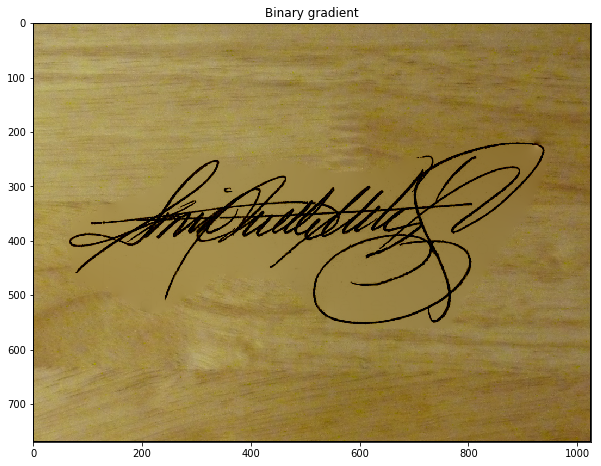

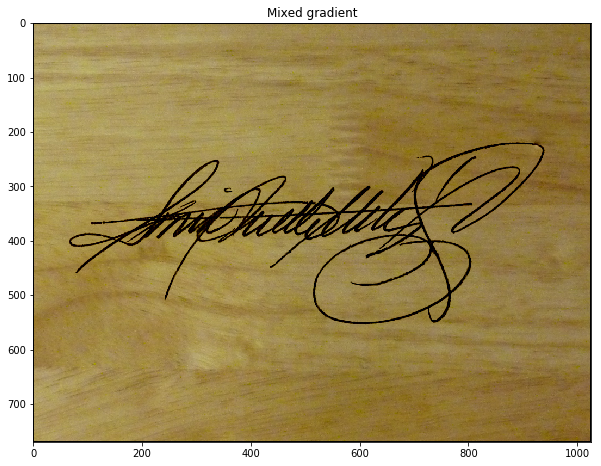

In [67]:
plt.figure(figsize=(10,10))
plt.imshow(im_bin[:,:,::-1]/255)
plt.title('Binary gradient')

plt.figure(figsize=(10,10))
plt.imshow(im_mix[:,:,::-1]/255)
plt.title('Mixed gradient')

In [37]:
# gradient image inversion
# reference: http://www.amitkagrawal.com/cvpr06/EdgeSuppression.html
im_flash = cv2.imread('MannequinFlash.png', cv2.IMREAD_COLOR).astype(np.float)
#im_flash = cv2.imread('flash_color.png', cv2.IMREAD_COLOR).astype(np.float)
im_flash = np.pad(im_flash,((1,1),(1,1),(0,0)),'constant')
H,W,C = im_flash.shape
im_recon = np.zeros((H,W,C))
for k in range(C):
    gx,gy = poissonImg.imgradient(im_flash[:,:,k])
    im_recon[:,:,k] = poissonImg.invgrad(gx,gy,np.zeros((H,W)))

err norm = 1.7013344143e-08


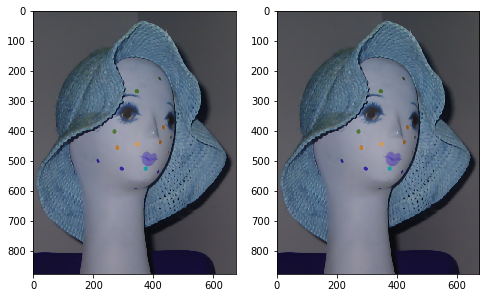

In [38]:
plt.figure(figsize=(8,16))
plt.subplot(121)
plt.imshow(im_flash/255)
plt.subplot(122)
plt.imshow(im_recon/255)
print('err norm = %s' % np.linalg.norm(im_recon-im_flash))